# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Загрузка и общий обзор данных

#### Загрузка данных

In [2]:
df_0 = pd.read_csv("geo_data_0.csv")
df_1 = pd.read_csv("geo_data_1.csv")
df_2 = pd.read_csv("geo_data_2.csv")

#### Описание столбцов

- id — уникальный идентификатор скважины;  
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  
- product — объём запасов в скважине (тыс. баррелей).

#### Обшая информация

In [3]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


**Вывод:** Данные загружены. Типы соответствуют ожидаемым. Пропусков нет.

### Дубликаты

In [9]:
df_0.duplicated().sum()

0

In [10]:
df_1.duplicated().sum()

0

In [11]:
df_2.duplicated().sum()

0

**Вывод:** Явных дубликатов нет.

### Выбросы, шкалирование, мультиколинеарность

#### Описательная статистика

In [12]:
df_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [13]:
df_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [14]:
df_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**Вывод:** Предварительно выбросов либо нет, либо их немного. Шкалирование признаков не обязательно.

#### Ящик с усами

##### Признаки

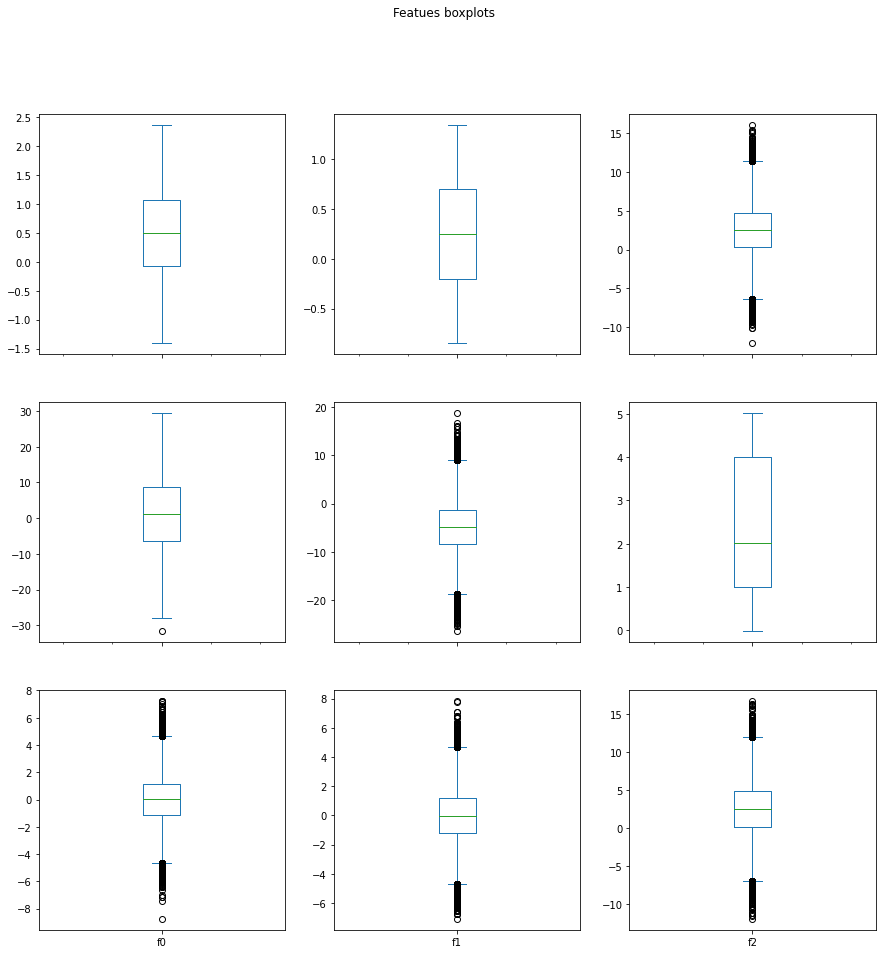

In [15]:
fig, ax = plt.subplots(3, 3, figsize=(15,15))
fig.suptitle('Featues boxplots')
for nd, d in enumerate([df_0, df_1, df_2]):
    for nf, f in enumerate(["f0", "f1", "f2"]):
        d[f].plot.box(ax=ax[nd, nf], sharex=True)

##### Целевая переменная

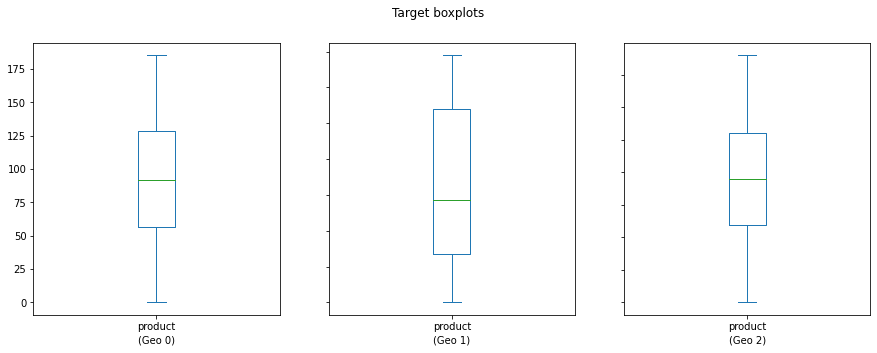

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Target boxplots')
for nd, d in enumerate([df_0, df_1, df_2]):
    d["product"].plot.box(ax=ax[nd], sharey=True)
    ax[nd].set_xlabel(f"(Geo {nd:d})")

**Вывод:** Выбросы по фичам есть, но не думаю что они скажутся. Можно обойтись без шкалирования признаков. По целевой переменной выбросы отсутствуют

#### Матрица диаграмм рассеяния

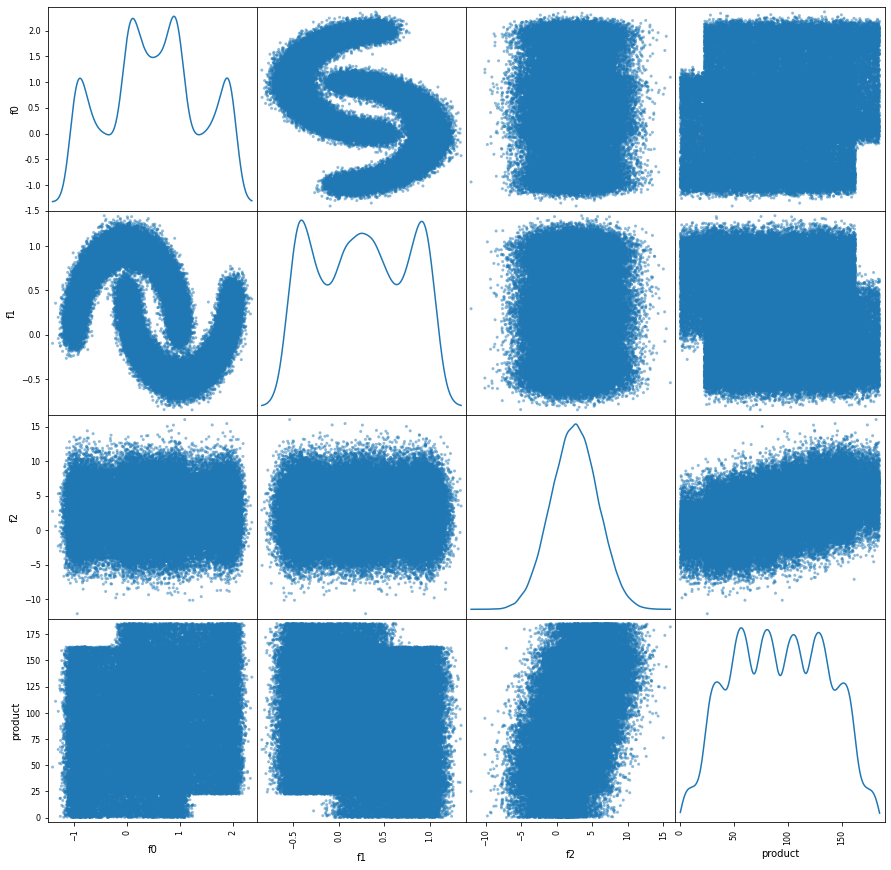

In [17]:
pd.plotting.scatter_matrix(df_0, diagonal="kde", figsize=(15, 15));

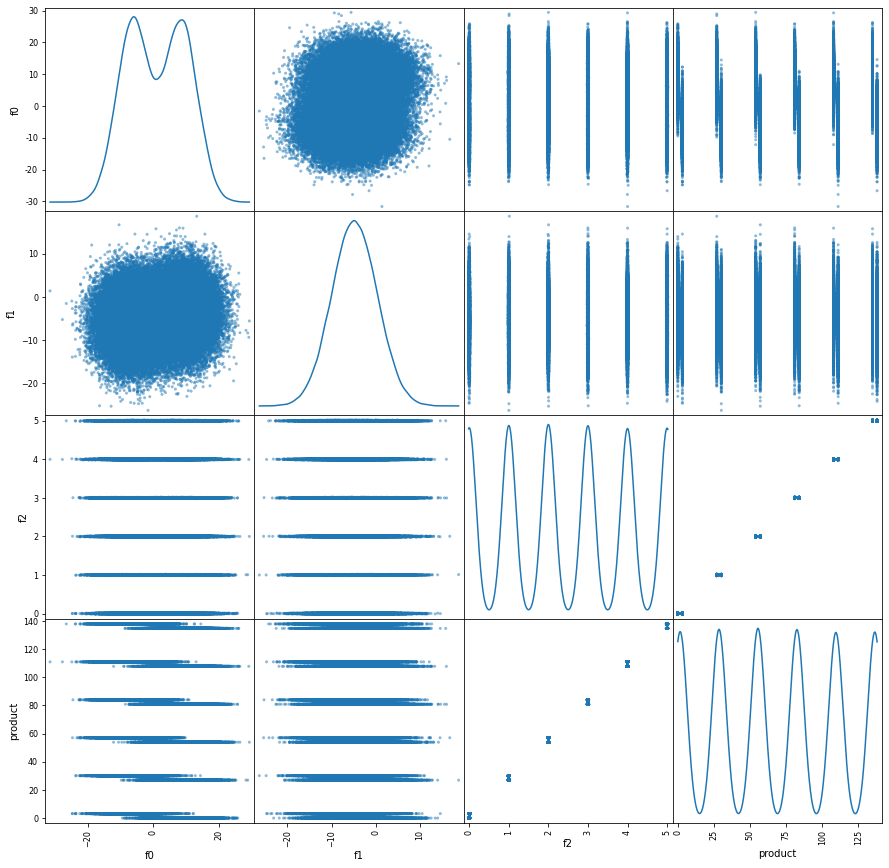

In [18]:
pd.plotting.scatter_matrix(df_1, diagonal="kde", figsize=(15, 15));

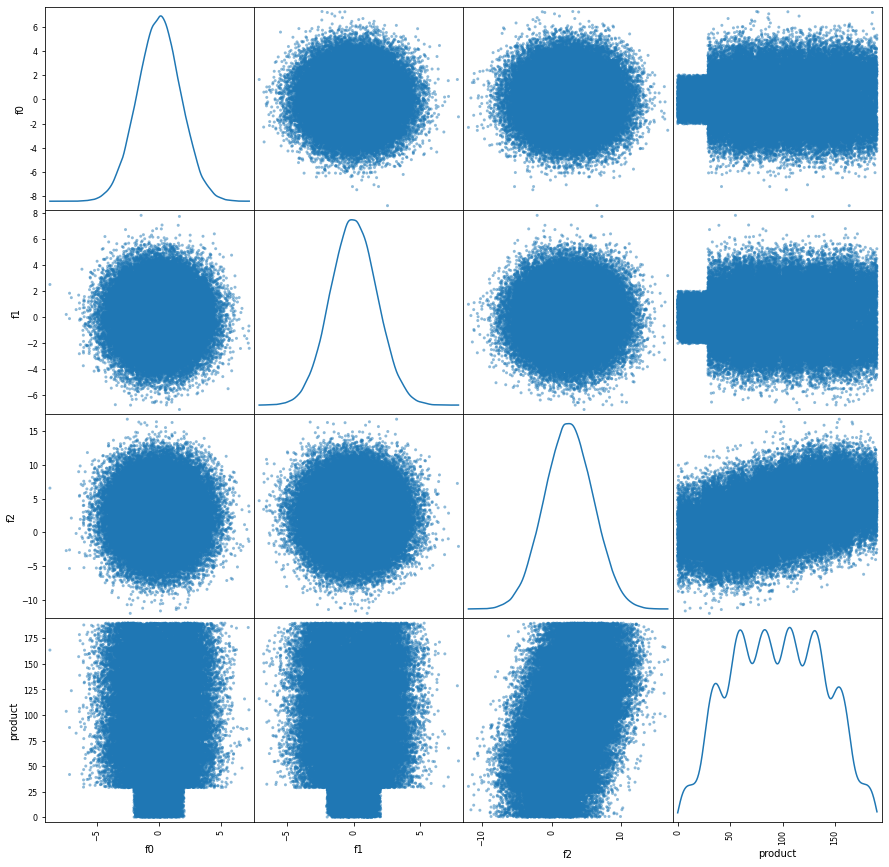

In [19]:
pd.plotting.scatter_matrix(df_2, diagonal="kde", figsize=(15, 15));

**Вывод:** Очень занятные распределения :-). Но тем не менее значимых линейных связей между признаками не найдено, кроме 2-го региона. 

## Обучение и проверка модели

Так как датасета у нас 3 то можно написать общую функцию которая разделит датасет, обучит модель валидирует её, посчитает среднее и ошибку. Дополним данные R2. Потом прогнать её в цикле для датасетов и аггрегировать все данныe.

In [20]:
def df_pred(df):
    features = df.drop(["product", "id"], axis=1)
    target = df["product"]
    X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred_valid = model.predict(X_valid)
    r2 = model.score(X_valid, y_valid)
    mean_pred = pred_valid.mean()
    rmse = mean_squared_error(y_valid, pred_valid, squared=False)
    return y_valid, pred_valid, mean_pred, rmse, r2
 

In [21]:
pred_list = []
res_list = []
for d in (df_0, df_1, df_2):
    y_true, y_pred, mean_pred, rmse, r2 = df_pred(d)
    y_pred = pd.Series(y_pred, index=y_true.index)
    pred_dict = {"y_true":y_true, "y_pred":y_pred}
    pred_list.append(pred_dict)
    res_dict = {"mean_pred":round(mean_pred,2), "rmse":round(rmse, 2), "r2":round(r2, 4)}
    res_list.append(res_dict)
res_df = pd.DataFrame(res_list, index=["Geo 0", "Geo 1", "Geo 2"])
res_df


,mean_pred,rmse,r2
Geo 0,92.59,37.58,0.2799
Geo 1,68.73,0.89,0.9996
Geo 2,94.97,40.03,0.2052


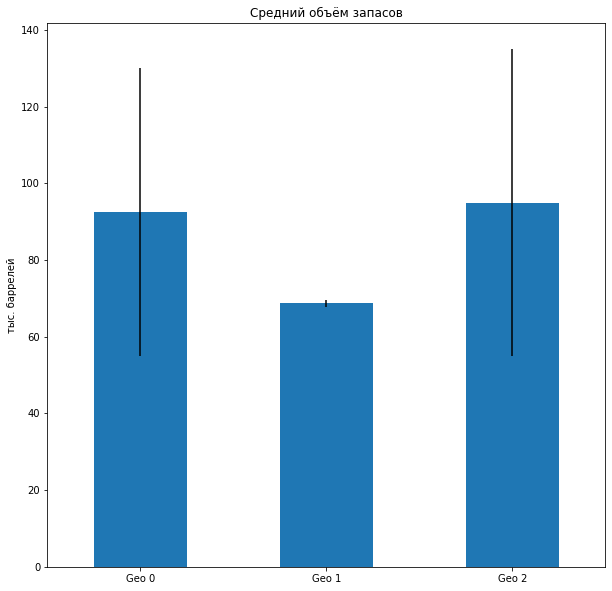

In [22]:
res_df['mean_pred'].plot(kind="bar", yerr=res_df["rmse"], 
                         title="Средний объём запасов", ylabel="тыс. баррелей", rot=0,
                         figsize=(10, 10));

**Вывод:** Средние предсказанные запасы в скважинах на участке 1 меньше, чем на 0 и 2. Однако качество модели на участке 1 значительно выше (по R2 и RMSE), поэтому ошибка предсказания значительно больше у 0 и 2 по сравнению с 1. 

## Подготовка к расчёту прибыли

### Определяем переменные.

In [23]:
BUDGET = 10_000_000_000
COST_PER_BAR = 450
N_BEST = 200
N_PROB = 500

### Точка безубыточности

In [24]:
break_even_vol = BUDGET/(COST_PER_BAR*N_BEST)
print(f"{break_even_vol/1000:.2f} тыс.баррелей.")

111.11 тыс.баррелей.


**Вывод:** Для всех трёх участков средние запасы меньше точки безубыточности. Поэтому случайный выбор 200 скважин не подойдёт для разработки.

### Определим функции расчёта прибыли.

In [25]:
def calc_net_revenue200(vol_200):
    return COST_PER_BAR*1000*vol_200 - BUDGET

In [26]:
def is_at_a_loss(net):
    return net < 0

In [27]:
def revenue(target, probs):
    probs_sorted = probs.sort_values(ascending=False)
    selected = target[probs_sorted.index][:N_BEST]
    return calc_net_revenue200(selected.sum())

## Расчёт прибыли и рисков 

Воспользуемся техникой бутстрепа. Определим функцию.

In [28]:
def bootstrap_net(pred):
    target = pred["y_true"]
    probabilities = pred['y_pred']
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=N_PROB, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index] 
        values.append(revenue(target_subsample, probs_subsample))
    values = pd.Series(values)
    mean = values.mean()
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    interval = (lower, upper)
    p_loss = is_at_a_loss(values).mean()*100
    return mean, interval, p_loss

Проведём бутстреп для трёх участков.

In [29]:
res_bs_list = []
for pred in pred_list:
    mean, interval, p_loss = bootstrap_net(pred)
    res_dict = {"Средняя прибыль (млн. р)":round(mean/10**6,2),
                "95% интервал (млн. р) ": np.fromiter(map(lambda x: round(x/10**6, 2), interval), dtype=np.float64),
                "p_loss":round(p_loss, 2)}
    res_bs_list.append(res_dict)
res_df = pd.DataFrame(res_bs_list, index=["Geo 0", "Geo 1", "Geo 2"])
res_df

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  selected = target[probs_sorted.index][:N_BEST]
<ipython-input-27-73bea3522840>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` loo

,Средняя прибыль (млн. р),95% интервал (млн. р),p_loss
Geo 0,425.94,"[-102.09, 947.98]",6.0
Geo 1,515.22,"[68.87, 931.55]",1.0
Geo 2,435.01,"[-128.88, 969.71]",6.4


**Вывод:** Больше всего подходит регион 2 (Geo 1). У него самый узкий доверительный интервал, самое высокое значение средней прибыли и вероятность убыточности 1%.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован